## Basic Setup

Run the cells below for the basic setup of this notebook.

In [1]:
try:
    from google.colab import drive # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False
    print('No colab environment, assuming local setup.')

if IN_COLAB:
    drive.mount('/content/drive')

    # TODO: Enter the foldername in your Drive where you have saved the unzipped
    # turorials folder, e.g. 'alphafold-decoded/tutorials'
    FOLDERNAME = None
    assert FOLDERNAME is not None, "[!] Enter the foldername."

    # Now that we've mounted your Drive, this ensures that
    # the Python interpreter of the Colab VM can load
    # python files from within it.
    import sys
    sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
    %cd /content/drive/My\ Drive/$FOLDERNAME

    print('Connected COLAB to Google Drive.')

import os
    
base_folder = 'geometry'
control_folder = f'{base_folder}/control_values'

assert os.path.isdir(control_folder), 'Folder "control_values" not found, make sure that FOLDERNAME is set correctly.' if IN_COLAB else 'Folder "control_values" not found, make sure that your root folder is set correctly.'

No colab environment, assuming local setup.


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from geometry.control_values.bunny_renderer import BunnyRenderer
from matplotlib import pyplot as plt
import torch
import math

In [4]:
torch.set_grad_enabled(False)

# Geometry

Three-dimensional geometry is an undeniably fascinating field, and yes, there's a bit of math involved. Luckily, it's the kind of math that opens up new ways of understanding the world. By the time you finish this notebook, you'll have done more than just implement key AlphaFold methods – you'll have a solid grasp of 3D movement, rotation matrices, quaternions, and homogenous coordinates. 

## Getting Started

Let's take a look at our test object in this notebook.

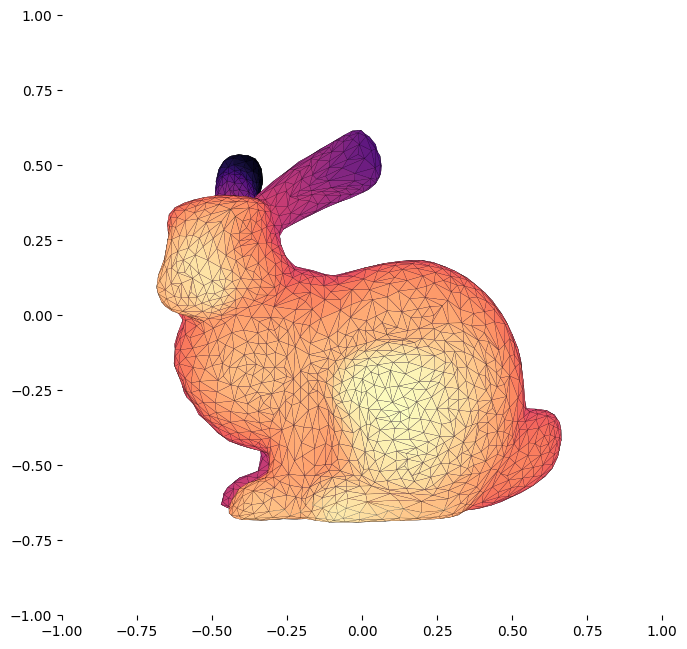

In [5]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1], xlim=[-1,+1], ylim=[-1,+1], aspect=1, frameon=False)

renderer = BunnyRenderer()
V = renderer.load_bunny(f'{control_folder}/bunny.obj')
renderer.render_bunny(V, ax)

When loading the bunny, the renderer returns the vertices of the mesh (a tensor of shape (2503, 3)). The vertices are the 3D positions of the corner points of the mesh you see. They can be manipulated before they are passed back to the render method. Try moving the rabbit around by adding an offset like `torch.tensor([0.5, 0, 0])` to them. In which directions are the x, y, and z axes of the coordinate frame pointing?

torch.Size([2503, 3])


(-1.0, 1.0)

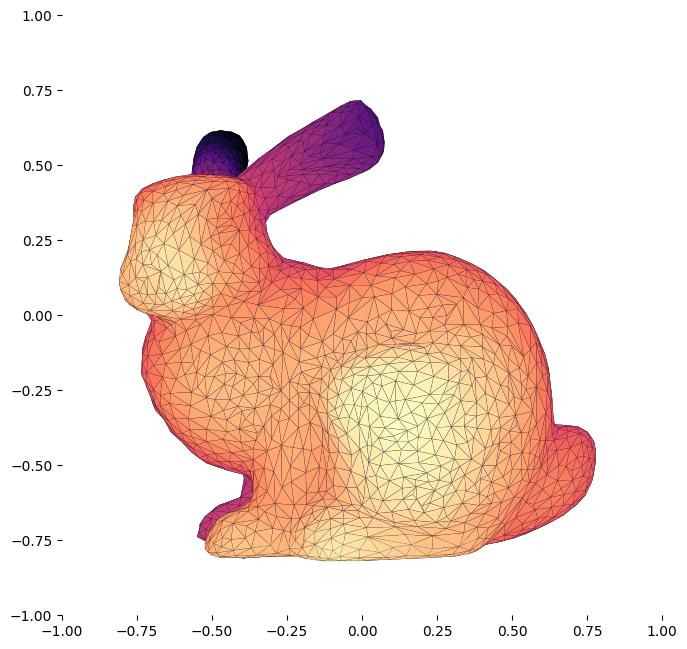

In [6]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1], xlim=[-1,+1], ylim=[-1,+1], aspect=1, frameon=False)
ax.clear()

renderer = BunnyRenderer()
V = renderer.load_bunny(f'{control_folder}/bunny.obj')


##########################################################################
# TODO: Move the bunny around by adding an offset to the vertices.       # 
#  In which directions are the x, y, and z axes pointing?                #
##########################################################################

print(V.shape)
V = V + torch.tensor([0, 0, 0.5])

##########################################################################
#               END OF YOUR CODE                                         #
##########################################################################

renderer.render_bunny(V, ax)
ax.set_xlim((-1, 1))
ax.set_ylim((-1, 1))


Point out the thumb, index and middle finger of your right hand, such that they are all orthogonal to each other. You will find there is only one way you can do this. Twist your hand so that your thumb is pointing in the direction of the x-axis and your index finger is pointing in the direction of the y-axis. Your middle finger should now align with the z-axis. Theoretically, there are two possible directions for the z-axis (the direction your middle finger is pointing, or the opposite one) and the vectors would still be orthogonal. But it is convention to choose the axes in the way done here. 

This is called a <b>right-handed coordinate system</b>.

Given the first two vectors, the third one is already defined, as you can see from the direction your middle finger is pointing after orienting thumb and index finger to your chosen orientation. As it is fully determined, there is also a mathematical formula to compute it, and it is called the cross-product. The cross-product of two orthogonal vectors is the vector that is orthogonal to both in a right-handed fashion. Its magnitude is the product of the magnitudes of the input vectors, so for unit vectors, it also is a unit vector.

## Rotation Matrices

Moving the bunny around is fun, but for a more serious analysis, we will have to rotate him as well. The most straight-forward method to describe 3D rotations is by rotation matrices. A rotation matrix is just any 3x3 matrix, where the three columns are orthogonal and unit vectors (orthonormal) and oriented in a right-handed fashion. The simplest rotation matrix is just the identity matrix, with 1 on the diagonal and 0s everywhere else. 

Try coming up with a set of three such vectors and combine them in a matrix, then multiply it against the vertices to rotate the bunny.

(-1.0, 1.0)

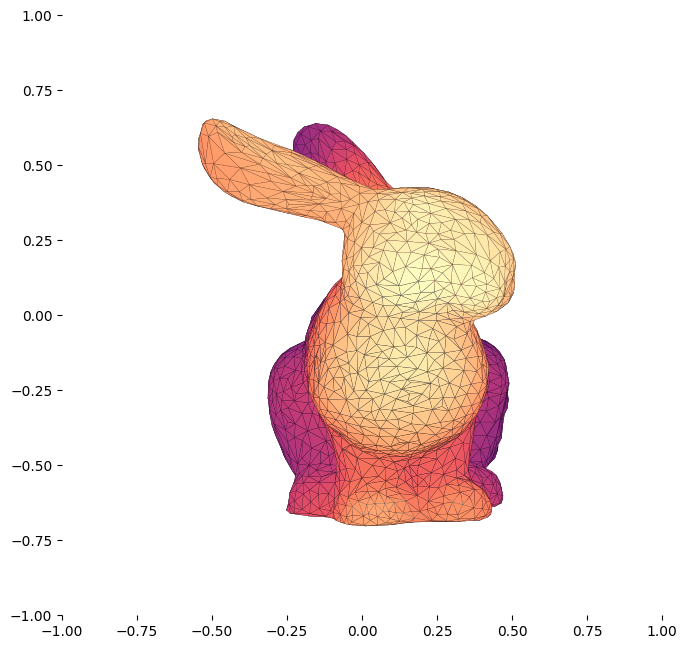

In [7]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1], xlim=[-1,+1], ylim=[-1,+1], aspect=1, frameon=False)

renderer = BunnyRenderer()
V = renderer.load_bunny(f'{control_folder}/bunny.obj')

rot_mat = None
warped_V = None

##########################################################################
# TODO: Create a rotation matrix by choosing three orthonormal vectors,  # 
#  that follow a right-handed orientation. You can achieve that by       #
#  finding two orthonormal vectors and then compute the third with       #
#  torch.linalg.cross as there cross product. Use torch.stack to stack   #
#  them as columns in a matrix. Then, use batched matrix multiplication  #
#  to multiply the matrix from the left against V to rotate the bunny.   #
#  You can use torch.einsum for this.                                    #
##########################################################################

v_1 = torch.Tensor([0, 0, 1])
v_2 = torch.Tensor([0, 1, 0])
v_3 = torch.linalg.cross(v_1, v_2)

rot_mat = torch.stack((v_1, v_2, v_3))

warped_V = torch.einsum('ik,jk->ji', rot_mat, V)

##########################################################################
#               END OF YOUR CODE                                         #
##########################################################################

assert torch.allclose(torch.eye(3), rot_mat@rot_mat.T, atol=1e-5), 'Columns are not orthonormal.'
assert abs(torch.linalg.det(rot_mat)-1) < 1e-3, 'Columns are not right-handed.'
assert torch.allclose(V, warped_V@rot_mat, atol=1e-5), 'rot_mat not multiplicated against V correctly.'

renderer.render_bunny(warped_V, ax)
ax.set_xlim((-1, 1))
ax.set_ylim((-1, 1))

Take a look at where the scut of the rabbit is facing. It was previously oriented to (1,0,0), the x-axis. It should now point in the direction you chose as the first column of the rotation matrix. The same holds for the top of the bunny. It was previously looking at (0, 1, 0) and should now be oriented towards the second column. Check this against the rotation matrix you chose.

This is exactly what a rotation matrix does: The columns, the axes of the new frame, define where the former base axes x, y and z are rotated towards, and all other parts follow accordingly.

### Orthogonalization

We have already seen that, given two orthogonal vectors, the last vector for the rotation matrix is uniquely defined as the cross-product of the first two. But what about choosing the second one? If you imagine a unit vector, the options for the second vector are the plane orthogonal to this vector. We can convert any vector (that is not a direct scaling of the first) to an orthogonal vector, by projecting it onto the normal plane. This process is called orthogonalization, and it's done by computing the part of the vector that is parallel to the first, and then subtracting it.

Given a unit-length vector $v$ and a vector $w$ to be orthogonalized, the parallel part is $(v\cdot w) v$, where $\cdot$ denotes the dot product of the two. The orthogonalized version is $\tilde{w} = w - (v\cdot w) v$. You can directly compute, that this vector is indeed orthogonal to $v$:
$$v \cdot (w- (v\cdot w) v) = v\cdot w - (v\cdot w) (v\cdot v) = v\cdot w - v\cdot w = 0$$
Here we used that $(v\cdot v)=1$, as $v$ is a unit vector. After orthogonalization, $\tilde{w}$ needs to be normalized to be of unit length.

This process is part of the method `create_3x3_rotation`, which takes two vectors `ex, ey` and creates a rotation matrix by normalizing `ex`, orthonormalizing `ey` and calculating the last new axis as the cross product. Implement the method and check your code by running the following cell:

In [8]:
from geometry.geometry import create_3x3_rotation

ex = torch.tensor([-0.6610, -0.7191,  0.1293])
ey = torch.tensor([-0.2309,  1.7710, -1.3062])
ex_batch = ex.broadcast_to(5, 3)
ey_batch = ey.broadcast_to(5, 3)

R = create_3x3_rotation(ex, ey)
R_batch = create_3x3_rotation(ex_batch, ey_batch)

R_exp = torch.tensor([[-0.6709, -0.6218,  0.4041],
                      [-0.7299,  0.4572, -0.5082],
                      [ 0.1312, -0.6359, -0.7605]])
R_exp_batch = R_exp.broadcast_to((5, 3, 3))

assert torch.allclose(R, R_exp, atol=1e-3), 'Error in single computation.'
assert torch.allclose(R_batch, R_exp_batch, atol=1e-3), 'Error in batched computation.'

## Quaternions

Quaternions have a simple motivation. Instead of coming up with all the directions the new axes should be pointing to, we define a rotation by a rotational axis, and an angle by which we want to rotate the points around the axis (counter-clockwise). For the start, let's picture a rotational axis of unit length $\bold{n}$, and another vector $\bold{v}$ that is *orthogonal*, and that we want to rotate around the axis.

As a helping vector, we will compute the cross-procut $\bold{n} \times \bold{v}$. Given the properties of the cross-product (orthogonal to both in a right-handed fashion, norm is product of the norms), $\bold{n} \times \bold{v}$ is the vector $\bold{v}$ rotated by 90° counter-clockwise around $\bold{n}$.

Placeholder for three images: $\bold{n}$ and $\bold{v}$ in side view, $\bold{n},\bold{v}$ and $\bold{n}\times\bold{v}$ in side view, $\bold{n}, \bold{v},\bold{n}\times\bold{v}$ and an arbitrary rotation of $\bold{v}$ in top view.

An arbitrary rotation of $\bold{v}$ boils down to choosing the right combination of $\bold{v}$ and $\bold{n}\times\bold{v}$. By trigonometry, this combination is given by 
$$\tilde{\bold{v}} = \cos(\theta)\cdot\bold{v} + \sin(\theta)\cdot (\bold{n}\times\bold{v})$$

Quaternions are, basically, a construction that supports this computation. A quaternion $\bold{q} = (a, \bold{v})$ consists of a scalar (a number) $a$ and a 3D vector $\bold{v}$. It can also be seen as a four element vector. The multiplication of two quaternions $\bold{q} = (a, \bold{v})$ and $\bold{p} = (b, \bold{w})$ is defined as 

$$\bold{q}\cdot \bold{p} = (ab - \bold{v}\cdot \bold{w}, a\cdot\bold{w} + b\cdot\bold{v} + \bold{v} \times \bold{w})$$

A good way to remember this term is to just combine the scalar and vector parts in all possible ways and see which evaluate to vectors, and which to scalars: Product of scalars, dot-product of vectors, scalar times vector, and vector cross-product.

Going back to our setting: Let's construct the quaternion $\bold{q} = (\cos(\theta), \sin(\theta)\cdot \bold{n})$ and interpret the vector $\bold{v}$ as the quaternion $(0, \bold{v})$. The product now evaluates to 
$$\bold{q} \cdot (0, \bold{v}) = (0\cdot \cos(\theta) - \bold{n}\cdot \bold{v}, \;\;\cos(\theta)\cdot\bold{v}+0\cdot\bold{n}+\sin(\theta)\cdot\bold{n}\times\bold{v}) = (0, \cos(\theta)\cdot\bold{v} + \sin(\theta)\cdot \bold{n}\times\bold{v})$$
Here, $\bold{n}\cdot\bold{v}$ is 0, since the vectors are orthogonal. As you can see, the multiplication policy for quaternions is designed to exactly fit our derivation of "rotation around an axis".

The conjugate $\bold{q}^*$ of a quaternion $\bold{q} = (a, \bold{v})$ is given by $\bold{q}^* = (a, -\bold{v})$. Given that the cross-product is anti-commutative ($\bold{a}\times\bold{b} = -\bold{b}\times\bold{a}$) we could have reached the same result by computing $(0, \bold{v}) \cdot \bold{q}^*$. You can see here that the quaternion multiplication is not commutative, i.e. you can't swap the positions of the vectors. It is, however, associative, meaning $(\bold{q} \times \bold{p}) \times \bold{r} = \bold{q}\times(\bold{p}\times\bold{r})$.

Given these properties, we could also construct $\bold{q} = (\cos(\theta/2), \sin(\theta/2) \cdot \bold{n})$, the rotation to the half-angle, and compute the full rotation as $\bold{q} \times \bold{q} \times (0, \bold{v})$, or by computing $\bold{q} \times (0, \bold{v}) \times \bold{q}^*$. We have proven that the  first part of this computation is rotation by $\theta/2$, and since the rotated vector is still orthogonal to $\bold{n}$, the second part is just rotating another time by $\theta/2$. The computation
$$\bold{q} \cdot (0, \bold{v}) \cdot \bold{q}^*$$
has the added benefit, that if $\bold{v}$ was not orthogonal but parallel to $\bold{n}$, it isn't affected at all. If we now consider an arbitrary vector \bold{v} that is neither orthogonal nor parallel, we can deconstruct it as $\bold{v} = \bold{v}_\perp + \bold{v}_{\parallel}$ and get
$$\bold{q}\cdot(0,\bold{v})\cdot\bold{q}^* = \bold{q}\cdot(0,\bold{v}_{\perp}) \cdot \bold{q}^* + \bold{q}\cdot (0, \bold{v}_\parallel) \cdot \bold{q}^* = (0, \bold{\tilde{v}_\perp}) + (0, \bold{v}_\parallel) = (0, \bold{\tilde{v}})$$
since rotating a non-orthogonal vector just means rotating the orthogonal part and keeping the parallel part.

Note also that quaternions can be chained to concatenate rotations. Since $(\bold{q}\bold{p})^* = \bold{p}^*\bold{q}^*$, you can just compute $\bold{q}\cdot\bold{p}$ ahead of time and use it to rotate the vector instead.

That was a lot of math, but with just a few takeaways:
* Quaternions are multiplied as $\bold{q}\cdot\bold{p} = (a, \bold{v}) \cdot (b, \bold{w}) = (ab-\bold{v}\cdot\bold{w}, a\bold{w}+b\bold{v}+\bold{v}\times\bold{w})$
* Rotational quaternions are constructed as $\bold{q} = (\cos(\theta/2), \sin(\theta/2) \cdot \bold{n})$, where $\bold{n}$ is the rotational axis and $\theta$ is the angle (positive for counter-clockwise rotation, negative for clockwise rotation).
* To rotate a vector $\bold{v}$ by a quaternion $\bold{q}$, we compute $\bold{q}\cdot(0,\bold{v}) \cdot \bold{q}^*$
* Concatenating two rotational quaternions $\bold{q}$ and $\bold{p}$ is done by multiplying them as $\bold{q}\cdot\bold{p}$. In this order, it means first rotating by $\bold{p}$, then by $\bold{q}$.

Everything else in the text was just about proving these facts.

To get started working with quaternions, head over to `geometry.py` and implement the methods `quat_from_axis` and `quat_mul`. After you are done, check your implementation by running the following cell.

In [9]:
from geometry.geometry import quat_from_axis, quat_mul

phi = torch.tensor(math.pi/4)
n = torch.tensor([0.2, 0.5, -0.3])
n = n / torch.linalg.vector_norm(n)

phi_batch = phi.broadcast_to(2, 5)
n_batch = n.broadcast_to(2, 5, 3)

q = quat_from_axis(phi, n)
q_batch = quat_from_axis(phi_batch, n_batch)

q_exp = torch.load(f'{control_folder}/quat_from_axis_check.pt')

assert torch.allclose(q, q_exp, atol=1e-5), 'Error in quat_from_axis, single use.'
assert torch.allclose(q_batch, q_exp.broadcast_to((2,5,4)), atol=1e-5), 'Error in quat_from_axis, batched use.'

p = torch.tensor([0.3, -0.4, 0.1, 0.8])
p_batch = p.broadcast_to(2, 5, 4)

pq  = quat_mul(p, q)
pq_batch = quat_mul(p_batch, q_batch)

pq_exp = torch.load(f'{control_folder}/quat_mul_check.pt')

assert torch.allclose(pq, pq_exp, atol=1e-5), 'Error in quat_mul, single use.'
assert torch.allclose(pq_batch, pq_exp.broadcast_to((2,5,4)), atol=1e-5), 'Error in quat_mul, batched use.'

We have determined that the rotation of a vector by a quaternion is computed as $\bold{q}\cdot(0, \bold{v}) \cdot \bold{q}^*$. Implement the methods `conjugate_quat` and `quat_vector_mul` and check your implementation with the following cell.

In [10]:
from geometry.geometry import conjugate_quat, quat_vector_mul

q = torch.tensor([0.3, -0.4, 0.1, 0.8])
q = q / torch.linalg.vector_norm(q)
q_copy = q.clone()
v = torch.tensor([4.0, 1.0, 2.0])

q_conj = conjugate_quat(q)
q_conj_batch = conjugate_quat(q.broadcast_to((3, 4, 4)))

q_conj_exp = torch.load(f'{control_folder}/quat_conjugate_check.pt')
q_conj_batch_exp = q_conj_exp.broadcast_to(3, 4, 4)

assert torch.allclose(q_copy, q, atol=1e-5), 'Conjugation is performed in-place (modifies q) but should be done out-of-place. Clone the quaternion before modification.'
assert torch.allclose(q_conj, q_conj_exp, atol=1e-5), 'Error in q_conj, single use.'
assert torch.allclose(q_conj_batch, q_conj_batch_exp, atol=1e-5), 'Error in q_conj, batched use.'

qv = quat_vector_mul(q, v)
qv_batch = quat_vector_mul(q.broadcast_to(3, 4, 4), v.broadcast_to(3,4,3))

qv_exp = torch.load(f'{control_folder}/quat_vector_check.pt')
qv_batch_exp = qv_exp.broadcast_to(3, 4, 3)

assert torch.allclose(qv, qv_exp, atol=1e-5), 'Error in quat_vector_mul, single use.'
assert torch.allclose(qv_batch, qv_batch_exp, atol=1e-5), 'Error in quat_vector_mul, batched use.'

So far, we discussed quaternions as a 'quality of life improvement', a more convenient formulation for rotations. But their real advantage lies deeper. Quaternions are inherently smooth. Any normalized quaternion (q /norm(q)) is a rotation, and similar quaternions correspond two similar rotations. Try that with rotation matrices: Changing the values by a bit just destroys the rotational properties, as the columns won't be orthonormal anymore. The set of rotation matrices is a complicated submanifold of all matrices. For quaternions, you can just generate a random 4-number vector and normalize it and you get a valid rotation. The resulting rotations will even form a uniform distribution.

This property is foundational for machine learning: During training, we start with random outputs and adjust them locally to improve their quality. Therefore, we need outputs that are somewhat working, even when random, and that respond smoothly to small changes. Alphafold does exactly this to predict the orientations of all individual amino acids: predicting a 4-element vector, then normalizing it.

You can immediately see the smoothness when interpolating between two rotations. For that, let's first construct two rotational quaternions `q1` and `q2` with `quat_from_axis`. Choose any quaternions you like. For example, you can go for $\pi/6$ around y-axis, then $\pi/6$ around x-axis for `q1` and $-\pi/6$ around y, then $-\pi/6$ around x for `q2`.


In [11]:
q1 = None
q2 = None

##########################################################################
# TODO: Create two rotational quaternions q1 and q2.                     # 
#   If you want to construct the quaternions as described above,         # 
#   you can multiplicate the individual quaternions to concatenate them. # 
##########################################################################

q1 = quat_from_axis(torch.Tensor([0]), torch.Tensor([0, 1, 0]))
q2 = quat_from_axis(torch.Tensor([torch.pi/3]), torch.Tensor([0, 1, 0]))

##########################################################################
#               END OF YOUR CODE                                         #
##########################################################################

assert torch.allclose(torch.linalg.vector_norm(q1, dim=-1), torch.tensor(1.0), atol=1e-5), 'q1 is not normalized, meaning it is no rotational quaternion.'
assert torch.allclose(torch.linalg.vector_norm(q2, dim=-1), torch.tensor(1.0), atol=1e-5), 'q2 is not normalized, meaning it is no rotational quaternion.'

In [12]:
from geometry.geometry import quat_from_axis, quat_vector_mul, quat_mul
from IPython.display import Video
import matplotlib.animation as animation

fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1], xlim=[-1,+1], ylim=[-1,+1], aspect=1, frameon=False)
renderer = BunnyRenderer()
V = renderer.load_bunny(f'{control_folder}/bunny.obj')

# FRAME_NUMBER around 50 will result in a smooth animation.
# You can reduce this (to 10 for example) during testing 
# so that rendering is quicker.
FRAME_NUMBER = 50
DURATION = 2000

def interpolation(t):
    V_warped = None

    ##########################################################################
    # TODO: Use the parameter t (range 0 to 1) to interpolate between q1     # 
    #   and q2. Warp the vertices V through the quaternion rotation, to      # 
    #   construct the rotated bunny. For this, you will need to explicitly   # 
    #   broadcast the interpolated quaternion, to match the dimensions of V. # 
    #   After you checked your result, you can increase FRAME_NUMBER above   #
    #   to create a smooth animation.                                        #
    ##########################################################################
    t = 3 * t**2 - 2 * t**3

    q = (1-t) * q1 + (t) * q2
    q = q / torch.linalg.vector_norm(q, keepdim=True)

    V_batch = V.shape[:-1]
    q = q.view(1, 4).broadcast_to(V_batch + (4,))

    V_warped = quat_vector_mul(q, V)

    ##########################################################################
    #               END OF YOUR CODE                                         #
    ##########################################################################
    
    return V_warped



def animate(frame_number, total_frames=FRAME_NUMBER):
    base = torch.cat((torch.linspace(0, 1, total_frames//2+1), torch.linspace(1, 0, total_frames//2+1)[1:-1]), dim=0)
    t = base[frame_number]

    V_warped = interpolation(t)
    renderer.render_bunny(V_warped, ax)
    ax.set_xlim((-1, 1))
    ax.set_ylim((-1, 1))

ani = animation.FuncAnimation(fig, animate, frames=FRAME_NUMBER, interval=DURATION // FRAME_NUMBER)

ani.save('bunny_animation.mp4', writer='ffmpeg')
plt.close()

Video('bunny_animation.mp4', embed=True, html_attributes="loop autoplay controls")

You should see a smooth interpolation between the initial and ending pose you chose. If your bunny shrunk in between, you forgot to normalize the quaternion after interpolation. Remember: Only unit quaternions correspond to rotations. If they aren't unit, they are also scaling the object. Imagine a line between two points on a circle. The points on the line won't be on the boundary of the circle. The same idea holds true in 4D, and by normalizing the quaternion, we are pushing the points on the circle again.

The animation will look a little jagged at the start and end, as the bunny is immediately switching direction. You can add ease-in and ease-out by passing $t$ through a function like $\operatorname{smoothstep}(t) = 3t^2 - 2t^3$. It maps [0,1] to [0,1], but it has derivative 0 at the start and end, so the animation accelerates and deaccelerates at start and end before switching direction. Try it out!

If you look closely, you will see that your animation (without smoothstep) isn't really at uniform speed. That is because we are projecting a straight line between to points on a circle on the circle boundary. In doing this, we are going through the area close to the start and end quicker than through the middle section. There is a quick fix for this, it is to use spherical linear interpolation instead. It's an easy formula and you can look it up if you want to. However, this is no problem for us. We aren't trying to interpolate between rotations as smoothly as possible, we just want to use quaternions as smooth outputs for our machine learning model.

### Back to Matrices
Alphafold uses quaternions as its output, because of their smooth and uniform properties. But after prediction of the quaternions, they are converted back to rotation matrices because they are more convenient. Luckily, constructing matrices from arbitrary linear transformations is easy. All we have to do is remap the unit vectors [1,0,0], [0,1,0], and [0,0,1], then assemble their mapped values as columns in a matrix. By definition, multiplying this matrix by [1,0,0],[0,1,0] or [0,0,1] will result in the mapped values we calculated. And any linear combination of them is mapped to the correct linear combination of the columns as well. This idea is the core concept of linear algebra, and you can go to whole lectures on it.

Go to `geometry.py` and implement `quat_to_3x3_rotation`. After you are done, check your implementation by running the following cell.

In [13]:
from geometry.geometry import quat_to_3x3_rotation

quat = torch.tensor([0.9830, 0.1294, 0.1294, 0.0170])

R = quat_to_3x3_rotation(quat)

a, b, c, d = torch.unbind(quat, dim=-1)

exp_R = [
    [a**2+b**2-c**2-d**2, 2*b*c-2*a*d, 2*b*d+2*a*c],
    [2*b*c+2*a*d, a**2-b**2+c**2-d**2, 2*c*d-2*a*b],
    [2*b*d-2*a*c, 2*c*d+2*a*b, a**2-b**2-c**2+d**2]
]
exp_R = [torch.stack(vals, dim=-1) for vals in exp_R]
exp_R = torch.stack(exp_R, dim=-2)


assert torch.allclose(R, exp_R, atol=1e-5)

For once, please look at the code we use for checking your results, particularly on the construction of the expected R. Compare it to Algorithm 23 from the paper, where Alphafold computes the updated backbone transforms. The formula in line 3 is exactly our formula for `exp_R`. This is all that hides behind that complicated term: They calculated the multiplication of the quat $(a, b, c, d)$ with the unit vectors [1, 0, 0], [0, 1, 0], and [0, 0, 1], then put the results into a matrix.

## Homogenous Coordinates

Homogenous coordinates follow a simple idea: Say you have a rotation matrix $R$ and a translation vector $t$. To warp a vector $x$, we can just compute $y = R\cdot x + t$. This seems simple enough, but consider the following 4x4 matrix and vector:

$$ T = \left(\begin{array}{c|c} R & t \\\hline 0\;0\;0 & 1\end{array}\right), \; \tilde{x} = \begin{pmatrix}x\\\hline 1 \end{pmatrix}$$

You can check that the following holds:
$$\tilde{y} = T \cdot \tilde{x}, \; \text{ where } \tilde{y} = \begin{pmatrix}y \\\hline 1\end{pmatrix}$$

This way, just by assembling R and t together in a matrix and padding with (0,0,0,1), we could compute the affine linear transformation $y = R\cdot x + t$ with just a linear matrix multiplication. It is a simple trick that is often used to describe motions (rotations and translations) jointly.

We'll start by implementing the method `assemble_4x4_transform` that assembles a rotation matrix $R$ and translation vector $t$ to a 4x4 matrix in the format described above. Check your implementation with the following cell.

In [14]:
from geometry.geometry import assemble_4x4_transform

R = torch.tensor([[ 0.7071, -0.7071,  0.0000],
                  [ 0.7071,  0.7071, -0.0000],
                  [ 0.0000,  0.0000,  1.0000]])
t = torch.tensor([2.0, 1.0, -1.0])

R_batch = R.broadcast_to((2, 1, 3, 3))
t_batch = t.broadcast_to((2, 1, 3))

T = assemble_4x4_transform(R, t)
T_batch = assemble_4x4_transform(R_batch, t_batch)

T_exp = torch.load(f'{control_folder}/assemble_4x4_check.pt')
T_batch_exp = T_exp.broadcast_to((2,1,4,4))

assert torch.allclose(T, T_exp, atol=1e-5), 'Error in single use.'
assert torch.allclose(T_batch, T_batch_exp, atol=1e-5), 'Error in batched use.'

Check for yourself that these 4x4 transforms are the equivalent of rotating, then translating a vector: In the following cell, match our affine transformation by using a 4x4 transform.

In [15]:
R = torch.tensor([[ 0.7071, -0.7071,  0.0000],
                  [ 0.7071,  0.7071, -0.0000],
                  [ 0.0000,  0.0000,  1.0000]])

t = torch.tensor([2.0, 1.0, -1.0])
x = torch.tensor([-1.0, 0.0, 3.0])

y = R@x + t

y_4x4 = None

##########################################################################
# TODO: Promote x to homogenous coordinates by padding with 1, create    # 
#   a 4x4 transform T from R and t, warp your padded x through T and     # 
#   select the 3D coordinates by dropping the fourth, homogenous one.    #
##########################################################################
pad = torch.ones(x.shape[:-1]+(1,))
x = torch.cat((x, pad))

T = assemble_4x4_transform(R, t)
y_4x4 = T @ x
y_4x4 = y_4x4[..., 0:3]


##########################################################################
#               END OF YOUR CODE                                         #
##########################################################################

assert torch.allclose(y, y_4x4)

We'll need this workflow - promoting a 3d vector to homogenous coordinates, warping it through a 4x4 transform, then dropping the homogenous coordinate again - on several occasions in the structure module. Implement the batched version `warp_3d_point` in `geometry.py`, then check your implementation by running the following cell.

In [16]:
from geometry.geometry import warp_3d_point

R = torch.tensor([[ 0.7071, -0.7071,  0.0000],
                  [ 0.7071,  0.7071, -0.0000],
                  [ 0.0000,  0.0000,  1.0000]])

t = torch.tensor([2.0, 1.0, -1.0])
T = assemble_4x4_transform(R, t)
x = torch.tensor([-1.0, 0.0, 3.0])

batch_shape = (2,1)
T_batch = T.broadcast_to(batch_shape+T.shape)
x_batch = x.broadcast_to(batch_shape+x.shape)

x_warped = warp_3d_point(T, x)
x_warped_batch = warp_3d_point(T_batch, x_batch)

x_exp = torch.load(f'{control_folder}/warp_3d_point.pt')

assert torch.allclose(x_exp, x_warped, atol=1e-5)
assert torch.allclose(x_warped_batch, x_exp.broadcast_to(batch_shape+x_exp.shape), atol=1e-5)

We've already made a quality-of-life improvement for creating rotation matrices. Instead of specifying all three columns, we are constructing them via the new `ex` direction, and an `ey` direction (that is being orthogonalized against `ex`) in `create_3x3_rotation`. Implement the method `create_4x4_transform` that takes these two directions and a translation, then using `create_3x3_rotation` and `assemble_4x4_transform`.

In [17]:
from geometry.geometry import create_4x4_transform

ex = torch.tensor([1.2,0.3,0.5])
ey = torch.tensor([1.6, -2.2, 0.3])
t = torch.tensor([0.4, 0.2, 0.85])

T = create_4x4_transform(ex, ey, t)
T_batch = create_4x4_transform(ex.broadcast_to(2,4,3), ey.broadcast_to(2,4,3), t.broadcast_to(2,4,3))

T_exp = torch.load(f'{control_folder}/create_4x4_T.pt')

assert torch.allclose(T, T_exp, atol=1e-5)
assert torch.allclose(T_batch, T_exp.broadcast_to(2,4,4,4), atol=1e-5)

For Alphafold, we'll need to invert transformations. Inverting matrices can be a little tricky, but rotation matrices are a convenient exception: The inverse of a rotation matrix $R$ is just its transpose $R^T$. Remember that the columns of rotation matrices are orthonormal: This means that their dot-product with themselves is 1, and with each other is 0. With the definition of matrix multiplication, we have that $R^T \cdot R = I$, which is the requirement for inverse matrices.

Inverting a translation is easy: If we added $t$, we can just subtract it again. Inverting a transform $(R, t)$ means combining these two. The inverse is $(R^T, -R\cdot t)$. This is easy to check:
$$(R^T, -R^Tt) \circ (R, t) x = (R^T, -R^Tt)(Rx+t) = R^T(Rx + t) - R^Tt = x + R^Tt- R^Tt = x$$

Use this to implement `invert_4x4_transform`: Extract `R` and `t`, compute rotation and translation for the inverse transform and assemble them to a 4x4 transform again. Check your code by running the following cell.

In [18]:
from geometry.geometry import invert_4x4_transform

T = torch.load(f'{control_folder}/create_4x4_T.pt')
T_batch = T.broadcast_to((5,1,4,4))

T_inv = invert_4x4_transform(T)
T_inv_batch = invert_4x4_transform(T_batch)

T_inv_exp = torch.load(f'{control_folder}/invert_4x4_T.pt')

assert torch.allclose(T_inv, T_inv_exp, atol=1e-5)
assert torch.allclose(T_inv_batch, T_inv_exp.broadcast_to(5,1,4,4), atol=1e-5)

Our last general, non-alphafold-specific geometry problem is creating rotation matrices for rotation around the x-axis. We will use them to implement the torsion angles of the side-chains. 

We already know how rotations around axes work: For a rotation by `phi` around the x-axis, we use the quaternion `(cos(phi/2), sin(phi/2)*[1,0,0])`.
We can then construct rotation matrices by applying the quaternions to the unit vectors [1,0,0] and so on, just like we did for the backbones. Here however, the resulting matrices are actually nice-looking: 

$$\begin{pmatrix}1 & 0 & 0 \\ 0 & \cos(\varphi) & -\sin(\varphi) \\ 0 & \sin(\varphi) & \cos(\varphi) \end{pmatrix}$$

We will use this formula to directly construct the rotation matrices. This is also necessary because of the way Alphafold is predicting torsion angles. Just like using quaternions instead of rotation matrices because they are smooth and uniform, Alphafold doesn't directly predict angles. Predicting angles is difficult: You would need a uniform distribution on $[0, 2\pi]$ (which is not easy, as network outputs default to normal distributions) and you have the annoying wrap-around property, that $\alpha \equiv \alpha + 2\pi$.

Instead, Alphafold is just predicting a 2D point and uses its angle with the x-axis as the angle. After normalizing this point, its coordinates are $(\cos(\varphi), \sin(\varphi))$. Using the formula of the rotation matrix, we can just transfer the normalized vector to the function and use its values without ever actually computing $\varphi$.

Implement the method `makeRotX` in `geometry.py` and check your implementation by running the following cell.

In [19]:
from geometry.geometry import makeRotX

phi = torch.tensor([math.cos(0.5), math.sin(0.5)])
phi_batch = phi.broadcast_to(5,3,2)

T = makeRotX(phi)
T_batch = makeRotX(phi_batch)

T_exp = torch.load(f'{control_folder}/makeRotX_T.pt')

assert torch.allclose(T, T_exp, atol=1e-5)
assert torch.allclose(T_batch, T_exp.broadcast_to(5,3,4,4), atol=1e-5)



## Going to Alphafold

We already got some impressions of how Alphafold represents geometry in its outputs: The rotations for the amino acid backbones are inferred as quaternions, which are converted to 3x3 rotation matrices. We didn't just talk about translations for them so far, but they are just predicted directly. Also, we hinted that for the prediction of side-chain atoms, Alphafold predicts the torsion angles as `(cos(phi), sin(phi))`. 

The somewhat difficult part is retrieving the actual 3D coordinates of the side-chain atoms from this representation. This is what we'll do for the rest of this notebook.

To understand the computations, we'll first need to understand the data we are starting with. Open up the file `residue_constants.py` and inspect the variables there. The file consists mostly of basic data: `chi_angles_mask`, `rigid_group_atom_positions`, `chi_angles_chain`, `atom_types`, and `restypes`. Additionally ,the file contains some utility wrappers for the data: `rigid_group_atom_position_map`, `atom_order`, `atom_local_positions`, `atom_frame_inds`, `atom_mask` (and some wrappers for `restype_order`).

We will go through each one of them and see how they store their data. Read through them carefully. Then, look at their format in `residue_constants.py` and make sure that you understand the representation.

1. `restypes`: You have worked with it before during feature extraction. It is a list of all one-letter amino acid codes and defines the order of them.
2. `atom_types`: Lists all heavy atoms that can be present in an amino acid, and defines their order. Each amino acid has only a subset of these atoms. `atom_order` maps the atom names to their index in the list.
3. `atom_mask`: Boolean tensor of shape (20, 37). Entry i,j determines whether or not the atom `j` is present in the amino acid `i`.


In [20]:
from geometry.residue_constants import atom_types, atom_mask, restype_order

seq = 'ALPHAFLD'
aa_atoms = None
seq_atom_mask = None

##########################################################################
# TODO: Familiarize yourself with the data structures by completing      # 
#    the following tasks:                                                #
#  1) Use atom_mask and atom_types, to construct a nested list aa_atoms, #
#       that lists heavy atoms for each amino acid (see exp_aa_atoms     #
#       below for the desired output).                                   #
#  2) atom_mask is a tensor of shape (20, 37). Convert the sequence      #
#       `seq` into a numerical tensor using `restype_order`. Then, use   #
#       this tensor as an index, to retrieve the sequence specific       #
#       atom mask of shape (N_res, 37), that shows which atoms exist     #
#       for each amino acid in the sequence.                             #
##########################################################################
aa_atoms = []
for i in range(20):
    aa_atoms.append([atom_types[j] for j in range(37) if atom_mask[i, j]])

seq_restype = [restype_order[s] for s in seq]
seq_atom_mask = [atom_mask[restype, :] for restype in seq_restype]
seq_atom_mask = torch.stack(seq_atom_mask)

##########################################################################
#               END OF YOUR CODE                                         #
##########################################################################

exp_seq_atoms = torch.load(f'{control_folder}/atom_mask_test.pt')
exp_aa_atoms = [['N', 'CA', 'C', 'CB', 'O'], ['N', 'CA', 'C', 'CB', 'O', 'CG', 'CD', 'NE', 'NH1', 'NH2', 'CZ'], ['N', 'CA', 'C', 'CB', 'O', 'CG', 'ND2', 'OD1'], ['N', 'CA', 'C', 'CB', 'O', 'CG', 'OD1', 'OD2'], ['N', 'CA', 'C', 'CB', 'O', 'SG'], ['N', 'CA', 'C', 'CB', 'O', 'CG', 'CD', 'NE2', 'OE1'], ['N', 'CA', 'C', 'CB', 'O', 'CG', 'CD', 'OE1', 'OE2'], ['N', 'CA', 'C', 'O'], ['N', 'CA', 'C', 'CB', 'O', 'CG', 'CD2', 'ND1', 'CE1', 'NE2'], ['N', 'CA', 'C', 'CB', 'O', 'CG1', 'CG2', 'CD1'], ['N', 'CA', 'C', 'CB', 'O', 'CG', 'CD1', 'CD2'], ['N', 'CA', 'C', 'CB', 'O', 'CG', 'CD', 'CE', 'NZ'], ['N', 'CA', 'C', 'CB', 'O', 'CG', 'SD', 'CE'], ['N', 'CA', 'C', 'CB', 'O', 'CG', 'CD1', 'CD2', 'CE1', 'CE2', 'CZ'], ['N', 'CA', 'C', 'CB', 'O', 'CG', 'CD'], ['N', 'CA', 'C', 'CB', 'O', 'OG'], ['N', 'CA', 'C', 'CB', 'O', 'CG2', 'OG1'], ['N', 'CA', 'C', 'CB', 'O', 'CG', 'CD1', 'CD2', 'CE2', 'CE3', 'NE1', 'CH2', 'CZ2', 'CZ3'], ['N', 'CA', 'C', 'CB', 'O', 'CG', 'CD1', 'CD2', 'CE1', 'CE2', 'OH', 'CZ'], ['N', 'CA', 'C', 'CB', 'O', 'CG1', 'CG2']]

assert aa_atoms == exp_aa_atoms
assert torch.all(exp_seq_atoms == seq_atom_mask)

4. `chi_angles_mask`: Nested list of shape (20, 4). The side chains of the amino acids are represented by up to four torsion angles, chi1 to chi4. Only Lysine and Arginine use all of them. This mask determines whether or not the angle is part of the amino acid.

5. `chi_angles_chain`: Stores lists of atom names along the primary side-chain that determines torsion angles for each amino acid. The primary side-chain is the linear sequence of atoms where changes in torsion angles directly impact the positioning of heavy atoms in the side-chain.



In [21]:
from geometry.residue_constants import chi_angles_chain, chi_angles_mask

chi_count_by_mask = None
chi_count_by_chain = None

##########################################################################
# TODO: Familiarize yourself with the data structures by completing      # 
#    the following tasks:                                                #
#   1) Use chi_angles_mask to compute the number of chi angles that      #
#       occur in the side-chain for every amino acid.                    #
#   2) Use chi_angles_chain to compute the number of chi angles that     #
#       occur in the side-chain for every amino acid.                    #
#   3) Use chi_angles_chain to retrieve the main side-chain of           #
#       Isoleucine. Look up the chemical structure of Isoleucine and     #
#       compare it to your result.                                       #
##########################################################################

# 1
chi_count_by_mask = [sum(row) for row in chi_angles_mask]

# 2
chi_count_by_chain = [len(l) for (k, l) in chi_angles_chain.items()]

# 3
print(chi_angles_chain['ILE'])

##########################################################################
#               END OF YOUR CODE                                         #
##########################################################################

assert chi_count_by_mask == [0, 4, 2, 2, 1, 3, 3, 0, 2, 2, 2, 4, 3, 2, 2, 1, 1, 2, 2, 1]
assert chi_count_by_mask == chi_count_by_chain

['CB', 'CG1']


6. `rigid_group_atom_positions`: This one needs a little more explaining. Alphafold defines eight coordinate frames, and all atoms have fixed position with respect to one of those coordinate frames. The backbone nitrogen for example is fixed with respect to the backbone group (index 0). The backbone Oxygen is fixed with respect to the psi-group (index 3) which is determined by the torsion angle $\psi$. The position of C-$\gamma$ (existing in amino acids like Arginine, Asparagine, Leucine) is fixed with respect to the $\chi_1$ group, which is determined by the first side-chain torsion angle $\chi_1$. C-$\delta$ (for amino acids like Glutamine, Lysine, ...) is fixed with respect to the $\chi_2$ group, which is determined by the side-chain torsion angles $\chi_1$ and $\chi_2$. `rigid_group_atom_positions` maps each amino acid to a list of all the heavy-atoms of the amino acids, together with the index of the coordinate frame they lie in and their position relative to this coordinate frame. 

    `rigid_group_atom_position_map` is a utility wrapper. For each amino acid, it maps the atom names to their positions. `atom_local_positions` is similar, but for batched use via the indices, not the names. It is a (20,37,3) tensor, containing the local positions for each amino acid and atom. Positions of atoms that are not present are set to 0. `atom_frame_inds` also is a tensor for batched use, with shape (20, 37) and type long. For each amino acid and atom, it contains the frame index of the coordinate frame the atom lies in.


Note: For the tasks in the following cell, we will use integer tensors to index into other tensors. This is called integer array indexing, and we didn't cover it in the tensor introduction. Using a one-dimensional index tensor is pretty straightforward, it's just replacing the dim you're indexing into by the dim of the index, using the indices to select the values:

In [22]:
A = torch.tensor([[0,1],[2,3],[4,5]])   # A has shape (3, 2)    
B = torch.tensor([2,0,0,1])             # B has shape (4,)      
C = A[B]                                                        
print(C)
print(C.shape)

tensor([[4, 5],
        [0, 1],
        [0, 1],
        [2, 3]])
torch.Size([4, 2])


For task 3, we are using a two-dimensional index of shape (N_res, 37). Multi-dimensional integer indexing can be a little complicated. For our case however, the first index is just for broadcasting: We want to perform the routine 'for each residue'. This type of broadcasted indexing follows a simple rule: Given A (n-dim source tensor), and an index I, that is 2-dim, and where the first dimension is shared with A, you construct B with `torch.arange` for the first dimension, broadcast it to the shape of I and select with A[B, I]. 

The [numpy documentation](https://numpy.org/doc/stable/user/basics.indexing.html#integer-array-indexing) provides a nice, general explanation of integer indexing, if you are curious, read up there. Selecting values with integer arrays is a bit tricky. There's
also `torch.gather` as a workable alternative, you can read the documentation [here](https://pytorch.org/docs/stable/generated/torch.gather.html) and try to use it for the task if you want to.

In [23]:
from geometry.residue_constants import atom_local_positions, atom_frame_inds
seq = 'ALPHAFLD'
N_res = len(seq)
# Dummy frames
frames_shape = (N_res, 8, 4, 4)
frames = torch.linspace(-2, 2, math.prod(frames_shape)).reshape(frames_shape)

seq_local_positions, seq_frame_inds, seq_frames = None, None, None

##########################################################################
# TODO: Convert the sequence to a long tensor. Then, practice index      # 
#   selection by completing the following tasks:                         # 
#    1) Use the indices to select the local positions of each atom for   #
#      each amino acid. The result should be of shape (N_res, 37, 3).    #
#    2) Use the indices to select the frame indices of each atom for     #
#      each amino acid. The result should be of shape (N_res, 37).       #
#    3) Use the frame indices to select the global frames of each atom   #
#      for each amino acid from the dummy frames `frames`.               #
#      The result should be of shape (N_res, 37, 4, 4).                  #
##########################################################################

seq_restype = torch.Tensor([restype_order[s] for s in seq]).long() # indices
print(seq_restype)

seq_local_positions = atom_local_positions[seq_restype, :]
print(seq_local_positions.shape)


seq_frame_inds = atom_frame_inds[seq_restype, :]
print(seq_frame_inds.shape)

print(frames.shape)
B = torch.arange(0, N_res, dtype=torch.long).unsqueeze(-1)
B = torch.broadcast_to(B, seq_frame_inds.shape)
seq_frames = frames[B, seq_frame_inds]
print(seq_frames.shape)


##########################################################################
#               END OF YOUR CODE                                         #
##########################################################################

local_pos_exp = torch.load(f'{control_folder}/local_pos_selection_test.pt')
frame_inds_exp = torch.load(f'{control_folder}/frame_inds_selection_test.pt')
frames_exp = torch.load(f'{control_folder}/frame_selection_test.pt')

assert torch.allclose(seq_local_positions, local_pos_exp, atol=1e-5)
assert torch.allclose(seq_frame_inds, frame_inds_exp, atol=1e-5)
assert torch.allclose(seq_frames, frames_exp, atol=1e-5)


tensor([ 0, 10, 14,  8,  0, 13, 10,  3])
torch.Size([8, 37, 3])
torch.Size([8, 37])
torch.Size([8, 8, 4, 4])
torch.Size([8, 37, 4, 4])


### The Eight Frames

Alphafold creates eight frames to describe the positions of all atoms of the amino acids: Four backbone frames and four side-chain frames. These frames are globalized by interjecting rotation transforms corresponding to the torsion angles. The eight frames are described by their position, the direction of their x-axis and the direction of their y-axis. The x-axis and y-axis are always chosen as two different bonds, which form a tetraeder angle (not orthogonal). Therefore, the y-axis is orthogonalized when constructing the transforms, and only x-axis is fully respected. Note that the concrete bond lengths and tetrahedral angles vary for the different amino acids. Because of that, there aren't eight frames in total, but eight frames per amino acid. We calculate them all individually based on the crystallographic data for the specific amino acids.

These are the four backbone frames:

- backbone_group: Sits on CA, x-axis along $\psi$-bond (CA->C), y-axis along $\varphi$-bond (CA->N). You can see this in `rigid_group_atom_positions`: N, CA, C and CB all have frame_index 0 (they are part of the backbone group), CA has position 0, C is pointing in the x-direction, and N is pointing in y-direction after orthogonalization. Therefore, the backbone-group is the identity transform.

- pre-omega-group: The omega-bond isn't used in Alphafold (each amino acid is positioned individually), so this group is empty. We give it the identity transform as value.

- phi-group: Sits on N, x-axis along the $\varphi$-bond (CA -> N), y-axis along the $\psi$-bond (CA->C). Contains no heavy atoms, as the amino group only contains hydrogens.

- psi-group: Sits on C, x-axis along $\psi$-bond (CA->C), y-axis along $\varphi$-bond, but reversed (N->CA). Contains the carbonyl oxygen.

We have already implemented `create_4x4_transform`, which takes two axis-directions (ex and ey) and the translation of the transform, and constructs a 4x4 transform from it. Use this method to implement `calculate_non_chi_transforms`. Note that the identity 4x4 transform is the identity rotation matrix and 0 transform, which means that it's just the identity 4x4 matrix.

In [24]:
from geometry.geometry import calculate_non_chi_transforms

transforms = calculate_non_chi_transforms()

transforms_exp = torch.load(f'{control_folder}/non_chi_transforms.pt')

assert torch.allclose(transforms, transforms_exp, atol=1e-5)

The four side-chain transformations are chained: Twisting along $\chi_1$ will also affect the downstream side-chain frames $\chi_2,\chi_3$ and $\chi_4$. We describe the positions of the frames with respect to the previous frame along the chain, i.e. $bb \rightarrow \chi_1 \rightarrow \chi_2 \rightarrow \chi_3 \rightarrow \chi_4$, where $bb$ is the backbone group. The frames are positioned along the main side-chain as defined by `chi_angles_chain` in residue_constants. The side-chain atoms are denoted as #SC0 - #SC3. The frames are the following:

- chi1: ex along the $\chi_1$ bond (CA -> #SC0), ey along the $\varphi$-bond (CA->N), sits on #SC0.

- chi2: ex along the $\chi_2$ bond (#SC0->#SC1), ey along the $\chi_1$-bond (#SC0->CA), sits on #SC1.

- chi3: ex along the $\chi_3$ bond (#SC1->#SC2), ey along the $\chi_2$-bond (#SC1->#SC0), sits on #SC2.

- chi4: ex along the $\chi_4$ bond (#SC2->#SC3), ey along the $\chi_3$-bond (#SC2->#SC1), sits on #SC3.

Note: All atoms in the definition of chi1 are in the backbone group, which is the parent of chi1. Therefore, we can directly use the local positions from `residue_constants` for the computation of the transform. 

In the definition of the frames chi2, chi3, and chi4, we have to take care, as they contain atoms from upstream frames: For chi2 for example, the position of #SC0 and CA is given with respect to the backbone frame, not the chi1 frame. You can see this in `rigid_group_atom_positions`: Look at arginine for example. The frame indices for CA and #SC0 (which is CB here) are 0, and not 4, which is the index of the chi1 transform, the direct parent of chi2.

But this is an easy fix: The position of the start of the x-axis (#SC0, #SC1, #SC2) are just 0 in the local frames, as #SC0, #SC1, and #SC2 are the roots of the frames chi1, chi2, and chi3. Therefore, we will just write pos[#SC1] instead of pos[#SC1] - pos[#SC0] for the computation of the x-axes. For the computation of the y-axis, note that they are just the inverse of the x-axis definition: The y-axis of chi2 is along #SC0->CA, and the x-axis of chi1 is #CA->#SC0. Therefore, in local coordinates, the y-axes for chi2, chi3 and chi4 are just (-1, 0, 0).

With this in mind, implement `calculate_chi_transforms`. After that, implement `precalculate_rigid_transforms`, which is just calling `calculate_non_chi_transforms` and `calculate_chi_transforms`, then concatenating them.

In [25]:
from geometry.geometry import calculate_chi_transforms, precalculate_rigid_transforms

chi_transforms = calculate_chi_transforms()
all_transforms = precalculate_rigid_transforms()

chi_transforms_exp = torch.load(f'{control_folder}/chi_transforms.pt')
all_transforms_exp = torch.load(f'{control_folder}/all_transforms.pt')

assert torch.allclose(chi_transforms, chi_transforms_exp, atol=1e-5)
assert torch.allclose(all_transforms, all_transforms_exp, atol=1e-5)



### Globalizing the Local Frames

So far, we have constructed the local frames for each rigid group. We constructed them in a way, that the x-axis of each frame points along the axes of the torsion angles. Therefore, we can just transform the local frames to global coordinates, by interjecting rotations along the x-axes between the frames, and applying the global transform for the whole amino acid backbone. This is done in `compute_global_transforms`: The method takes the global backbone transforms `T` if shape (N_res, 4, 4), the seven torsion angles of shape (N_res, 7, 2) (not given directly as angles, but as (cos(phi), sin(phi)), therefore the 2-dimension), and the labels for each amino acid of shape (N_res,). These labels are used to select the correct local transforms, as each amino acid has different local transforms.

It computes eight global transforms per residue, for each of the eight rigid groups. These global transforms are then used to compute all atom coordinates. Follow the instructions in `compute_global_transforms` to implement the method, then check your code by running the following cell.

In [26]:
from geometry.geometry import compute_global_transforms

N_res = 5
T = torch.linspace(-4, 4, N_res*4*4).reshape(N_res, 4, 4)
alpha = torch.linspace(-3, 3, N_res*7*2).reshape(N_res, 7, 2)
F = torch.tensor([4, 0, 18, 2, 0], dtype=torch.int64)

global_transforms = compute_global_transforms(T, alpha, F)

global_transforms_exp = torch.load(f'{control_folder}/global_transforms.pt')

assert torch.allclose(global_transforms, global_transforms_exp, atol=1e-5)

### Computing the Atom Coordinates

We now have all parts together: We know all global transforms for all amino acids, we know the local positions of the atoms in the frames (`atom_local_positions` in `residue_constants.py`) and we know the indices of the frames they belong to (`atom_frame_inds` in `residue_constants`). All that is left to do is selecting the local positions and frame inds using the amino acid labels, selecting the global transforms using the frame indices, and warping the local positions through the 4x4 transform. 

We have already implemented this selection process in this notebook, in the third code cell of 'Going to Alphafold'. You can look back at your code to see how you did it, especially for the selection of the global transforms using the frame indices. 

Follow the steps in `compute_all_atom_coordinates` to implement the method. After you're done, check your implementation by running the following cell.

In [30]:
from geometry.geometry import compute_all_atom_coordinates

N_res = 5
T = torch.linspace(-4, 4, N_res*4*4).reshape(N_res, 4, 4)
alpha = torch.linspace(-3, 3, N_res*7*2).reshape(N_res, 7, 2)
F = torch.tensor([4, 0, 18, 2, 0], dtype=torch.int64)

atom_positions, atom_mask = compute_all_atom_coordinates(T, alpha, F)

atom_positions_exp = torch.load(f'{control_folder}/global_atom_positions.pt')
atom_mask_exp = torch.load(f'{control_folder}/global_atom_mask.pt')

assert torch.allclose(atom_positions, atom_positions_exp, atol=1e-5)
assert torch.allclose(atom_mask, atom_mask_exp, atol=1e-5)